# Machine Learning Challenge

### --------------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------------
# 1) Data Preprocessing

### 1.1) Read input data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# seed for reproducibility
np.random.seed(1234)

# read data
df = pd.read_csv(os.path.join('data', 'train.csv'))
df_test = pd.read_csv(os.path.join('data', 'test.csv'))

# size of the dataset
N = df.shape[0]
d = df.shape[1]-2
N_test = df_test.shape[0]

# numerical variables
col_num = df.select_dtypes(include=[np.number]).columns

# categorical variables
col_cat = df.select_dtypes(exclude=[np.number]).columns

print('-----------')
print(f'Training Dataset size | N: {N} | d: {d}')
print('-----------')
print(f'Numerical variables: {col_num.values}')
print('-----------')
print(f'Categorical variables: {col_cat.values}')
print('-----------')
print(f'Test Dataset size | N: {N_test}')

-----------
Training Dataset size | N: 13370 | d: 13
-----------
Numerical variables: ['product_price_tier' 'product_periodicity' 'product_free_trial_length'
 'onboarding_birth_year' 'net_purchases_15d' 'net_purchases_1y']
-----------
Categorical variables: ['uid' 'install_timestamp' 'free_trial_timestamp' 'country' 'language'
 'device_type' 'os_version' 'attribution_network' 'onboarding_gender']
-----------
Test Dataset size | N: 3342


### 1.2) Nans treatment <a id='nans'></a>
Both for the training and the test dataset, I decide to fill the nans ofn the numerical variables with the overall meana and the nans of the categorical variables with the overall mode. They are very few, so I don't expect to introduce large biases.

------------------
Training Set
------------------
% of NANs in numerical variables Train Set
onboarding_birth_year        0.018773
product_price_tier           0.000000
product_periodicity          0.000000
product_free_trial_length    0.000000
net_purchases_15d            0.000000
net_purchases_1y             0.000000
dtype: float64
-----------
% of NANs in categorical variables Train Set
onboarding_gender       0.018773
attribution_network     0.005684
free_trial_timestamp    0.000449
country                 0.000150
uid                     0.000000
install_timestamp       0.000000
language                0.000000
device_type             0.000000
os_version              0.000000
dtype: float64
------------------
Test Set
------------------
% of NANs in numerical variables Test Set
onboarding_birth_year        0.018851
product_price_tier           0.000000
product_periodicity          0.000000
product_free_trial_length    0.000000
net_purchases_15d            0.000000
dtype: float64


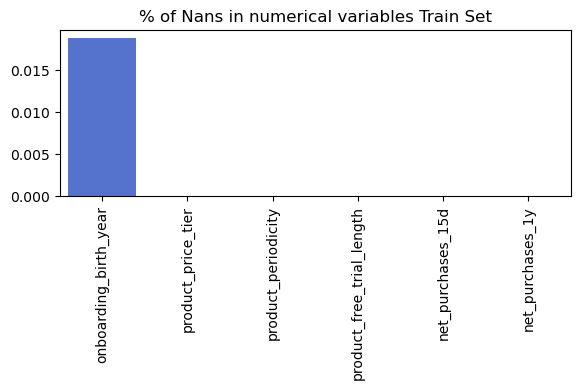

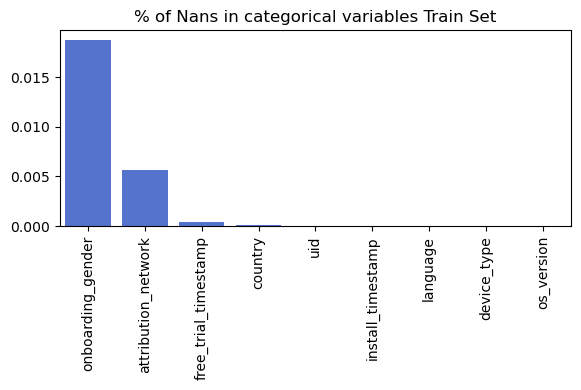

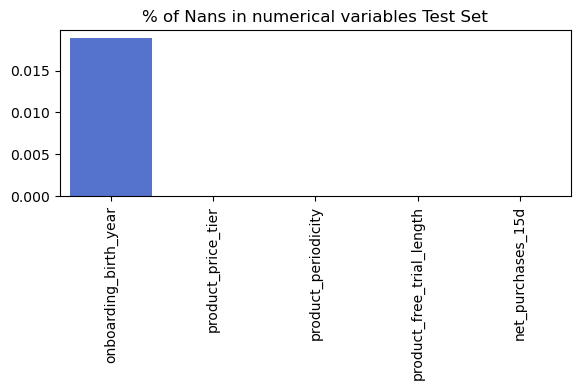

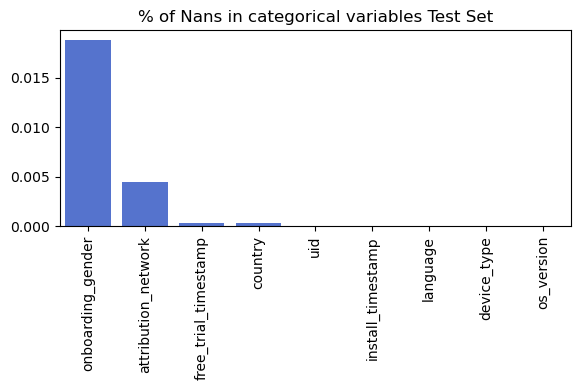

In [2]:
#####################
# Training Set
print('------------------')
print('Training Set')
print('------------------')

# percentage of NANs for numerical variables 
num_nan = df[col_num].isnull().sum()/N
num_nan = num_nan.sort_values(ascending=False)

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.barplot(x=num_nan.index, y=num_nan.values, ax=ax, color='royalblue')
plt.xticks(rotation=90)
ax.set_title('% of Nans in numerical variables Train Set')
fig.tight_layout()

print('% of NANs in numerical variables Train Set')
print(num_nan)


# percentage of NANs for categorical variables
cat_nan = df[col_cat].isnull().sum()/N
cat_nan = cat_nan.sort_values(ascending=False)

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.barplot(x=cat_nan.index, y=cat_nan.values, ax=ax, color='royalblue')
plt.xticks(rotation=90)
ax.set_title('% of Nans in categorical variables Train Set')
fig.tight_layout()

print('-----------')
print('% of NANs in categorical variables Train Set')
print(cat_nan)

# fill nans with the mean value
for col in col_num:
    df[col] = df[col].fillna(df[col].mean())
    
# fill nans with the median value
for col in col_cat:
    df[col] = df[col].fillna(df[col].mode()[0])


#####################
# Test Set
print('------------------')
print('Test Set')
print('------------------')

# percentage of NANs for numerical variables
num_nan_test = df_test[col_num[:-1]].isnull().sum()/N_test
num_nan_test = num_nan_test.sort_values(ascending=False)

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.barplot(x=num_nan_test.index, y=num_nan_test.values, ax=ax, color='royalblue')
plt.xticks(rotation=90)
ax.set_title('% of Nans in numerical variables Test Set')
fig.tight_layout()

print('% of NANs in numerical variables Test Set')
print(num_nan_test)


# percentage of NANs for categorical variables
cat_nan_test = df_test[col_cat].isnull().sum()/N_test
cat_nan_test = cat_nan_test.sort_values(ascending=False)

fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.barplot(x=cat_nan_test.index, y=cat_nan_test.values, ax=ax, color='royalblue')
plt.xticks(rotation=90)
ax.set_title('% of Nans in categorical variables Test Set')
fig.tight_layout()

print('-----------')
print('% of NANs in categorical variables Test Set')
print(cat_nan_test)


# fill nans with the mean value
for col in col_num[:-1]:
    df_test[col] = df_test[col].fillna(df_test[col].mean())
    
# fill nans with the median value
for col in col_cat:
    df_test[col] = df_test[col].fillna(df_test[col].mode()[0])

### 1.3) Feature extraction
I extract or modify significantly the follwing features:
1. 'time_to premium': time waited to pass to premium account expressed in hours;
2. 'macro-region': macro region where each country belongs to;
3. 'country': I assign else value to countries with low cardinality;
4. 'macro-device': tell if the device is 'iphone' or any other;
5. 'os_version': make it numerical, cutting off the info of the sub-sub version (I just focus on the main releases);
6. 'product_periodicity': make it categorical

In [3]:
# 1) 'time_to_premium'
df['install_timestamp'] = pd.to_datetime(df['install_timestamp'])
df['free_trial_timestamp'] = pd.to_datetime(df['free_trial_timestamp'])
df_test['install_timestamp'] = pd.to_datetime(df_test['install_timestamp'])
df_test['free_trial_timestamp'] = pd.to_datetime(df_test['free_trial_timestamp'])

df['time_to premium'] = (df['free_trial_timestamp'] - df['install_timestamp'])/np.timedelta64(1,'h')
df_test['time_to premium'] = (df_test['free_trial_timestamp'] - df_test['install_timestamp'])/np.timedelta64(1,'h')


# 2) 'macro-region'
country_list = np.sort(df['country'].unique())

def macro_region(country):
    if country in ['DZ', 'EG', 'EH', 'LY', 'MA', 'SD', 'SS', 'TN', 'BF', 'BJ', 'CI', 'CV', 'GH', 'GM', 'GN', 'GW', 'LR', 'ML', 
                   'MR', 'NE', 'NG', 'SH', 'SL', 'SN', 'TG', 'AO', 'CD', 'ZR', 'CF', 'CG', 'CM', 'GA', 'GQ', 'ST', 'TD',
                   'BI', 'DJ', 'ER', 'ET', 'KE', 'KM', 'MG', 'MU', 'MW', 'MZ', 'RE', 'RW', 'SC', 'SO', 'TZ', 'UG', 'YT', 'ZM', 'ZW',
                   	'BW', 'LS', 'NA', 'SZ', 'ZA']:
        return 'Africa'   
    if country in ['GG', 'JE', 'AX', 'DK', 'EE', 'FI', 'FO', 'GB', 'IE', 'IM', 'IS', 'LT', 'LV', 'NO', 'SE', 'SJ']:
        return 'Northen-Europe'
    if country in ['AT', 'BE', 'CH', 'DE', 'DD', 'FR', 'FX', 'LI', 'LU', 'MC', 'NL']:
        return 'Western-Europe'
    if country in ['BG', 'BY', 'CZ', 'HU', 'MD', 'PL', 'RO', 'RU', 'SU', 'SK', 'UA', 'XK']:
        return 'Eastern-Europe'
    if country in ['AD', 'AL', 'BA', 'ES', 'GI', 'GR', 'HR', 'IT', 'ME', 'MK', 'MT', 'RS', 'PT', 'SI', 'SM', 'VA', 'YU']:
        return 'Southern-Europe'
    if country in ['BM', 'CA', 'GL', 'PM', 'US']:
        return 'Northen-America'
    if country in ['AG', 'AI', 'AN', 'AW', 'BB', 'BL', 'BS', 'CU', 'DM', 'DO', 'GD', 'GP', 'HT', 'JM', 'KN', 'KY', 'LC', 'MF', 'MQ', 'MS', 'PR', 'TC', 'TT', 'VC', 'VG', 'VI',
                   'BZ', 'CR', 'GT', 'HN', 'MX', 'NI', 'PA', 'SV', 'AR', 'BO', 'BR', 'CL', 'CO', 'EC', 'FK', 'GF', 'GY', 'PE', 'PY', 'SR', 'UY', 'VE']:
        return 'Latin-America-Caribbean'
    if country in ['AE', 'AM', 'AZ', 'BH', 'CY', 'GE', 'IL', 'IQ', 'JO', 'KW', 'LB', 'OM', 'PS', 'QA', 'SA', 'NT', 'SY', 'TR', 'YE', 'YD', 'TM', 'TJ', 'KG', 'KZ', 'UZ', 'AF', 'MN', ]:
        return 'Western-Central-Asia'
    if country in ['BD', 'BT', 'IN', 'IR', 'LK', 'MV', 'NP', 'PK', 'BN', 'ID', 'KH', 'LA', 'MM', 'BU', 'MY', 'PH', 'SG', 'TH', 'TL', 'TP', 'VN', 'JP', 'CN', 'HK', 'KR', 'TW']:
        return 'Southern-Eastern-Asia'
    if country in ['AU', 'NF', 'NZ', 'FJ', 'NC', 'PG', 'SB', 'VU', 'FM', 'GU', 'KI', 'MH', 'MP', 'NR', 'PW', 'AS', 'CK', 'NU', 'PF', 'PN', 'TK', 'TO', 'TV', 'WF', 'WS', 'AQ']:
        return 'Oceania' 
    else:
        return 'not-available'
    
df['macro-region'] = df['country'].apply(macro_region)
df_test['macro-region'] = df_test['country'].apply(macro_region)


# 3) 'country'
low_card_countries = df['country'].value_counts()[df['country'].value_counts() < 100].index.values
df['country'][df['country'].apply(lambda x: x in low_card_countries)] = 'else'
df_test['country'][df_test['country'].apply(lambda x: x in low_card_countries)] = 'else'
    

# 4) 'macro-device'
df['macro-device'] = df['device_type']
df['macro-device'][df['device_type'].str.contains('phone', case=False)] = 'iPhone'
df['macro-device'][df['device_type'].str.contains('pad', case=False)] = 'else'
df['macro-device'][df['device_type'].str.contains('pod', case=False)] = 'else'
df_test['macro-device'] = df_test['device_type']
df_test['macro-device'][df_test['device_type'].str.contains('phone', case=False)] = 'iPhone'
df_test['macro-device'][df_test['device_type'].str.contains('pad', case=False)] = 'else'
df_test['macro-device'][df_test['device_type'].str.contains('pod', case=False)] = 'else'


# 5) 'os_version'
def cut_version(version):
    return version[:4]

df['os_version'] = df['os_version'].apply(cut_version)
df['os_version'] = df['os_version'].apply(np.float64)
df_test['os_version'] = df_test['os_version'].apply(cut_version)
df_test['os_version'] = df_test['os_version'].apply(np.float64)


# 6) 'product_periodicity'
df['product_periodicity'][df['product_periodicity']==7] = 'week'
df['product_periodicity'][df['product_periodicity']==30] = 'month'
df['product_periodicity'][df['product_periodicity']==365] = 'year'
df_test['product_periodicity'][df_test['product_periodicity']==7] = 'week'
df_test['product_periodicity'][df_test['product_periodicity']==30] = 'month'
df_test['product_periodicity'][df_test['product_periodicity']==365] = 'year'


# recheck numerical and categorical variables
col_cat = df.select_dtypes(exclude=[np.number]).columns
col_num = df.select_dtypes(include=[np.number]).columns

### 1.4) Outlier treatment <a id='outliers'></a>
I see the feature 'onboarding_birth_year' has irrealistic values (year of subscription >= 2015). Since they are just 5 values, I set to them the year 2015. 

In [4]:
df['onboarding_birth_year'][df['onboarding_birth_year'].values > 2014] = 2015
df_test['onboarding_birth_year'][df_test['onboarding_birth_year'].values > 2014] = 2015

### 1.5) Visual inspection of variables versus target
I visually inspect the variables in this way:

1. I plot the boxplot of the target variable grouped by the values assumed by the categorical variables.
2. I do the pairplot of the continuous variables.
3. I compute the correlation coefficient for each pair of the continuous variables.

From the visual analysis I don't see any particular strong relation between the variables and the target, apart for the extremely high positive correlation that exists between 'net_purchase_15d' and 'net_purchase_1y'.

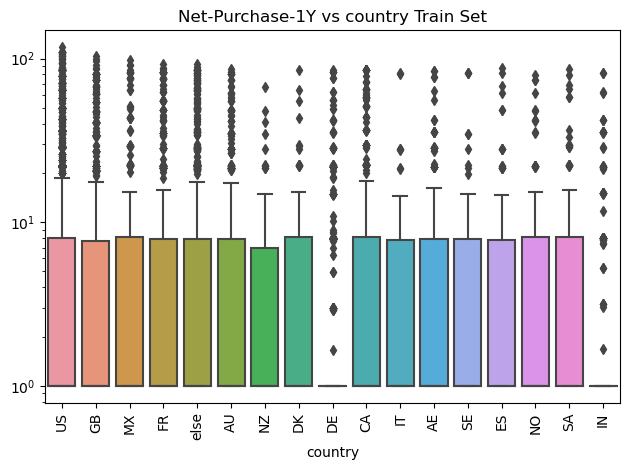

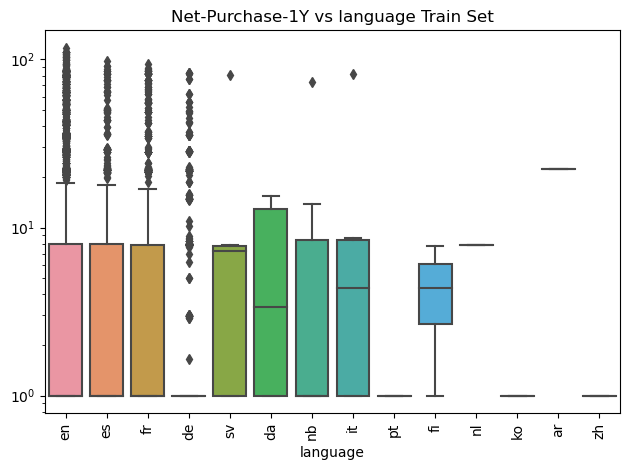

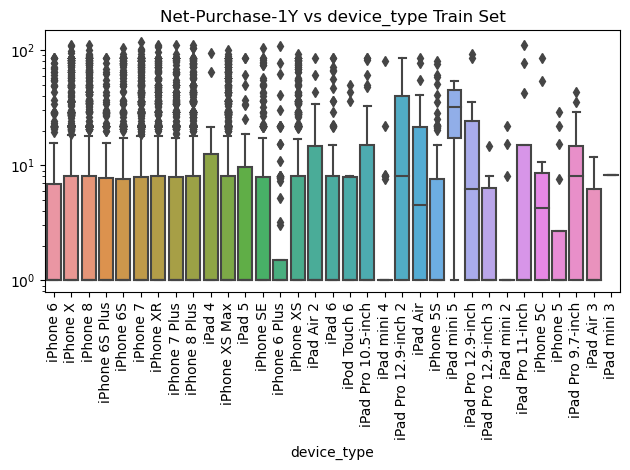

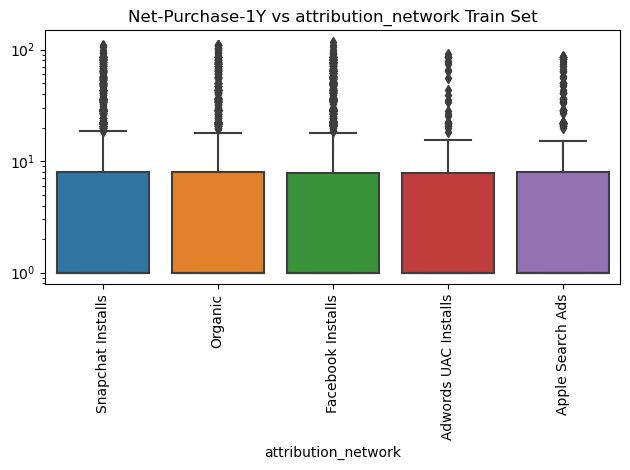

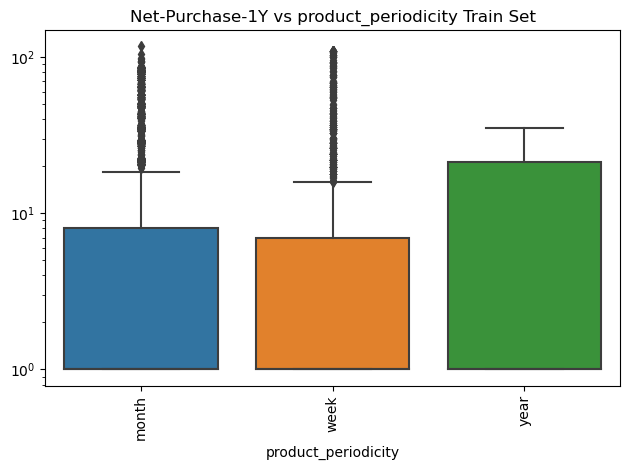

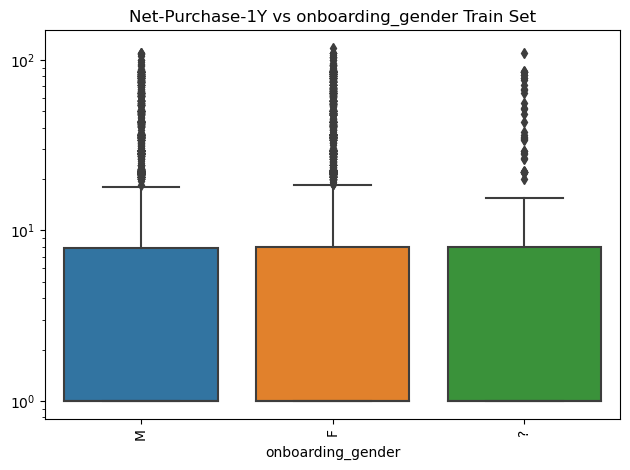

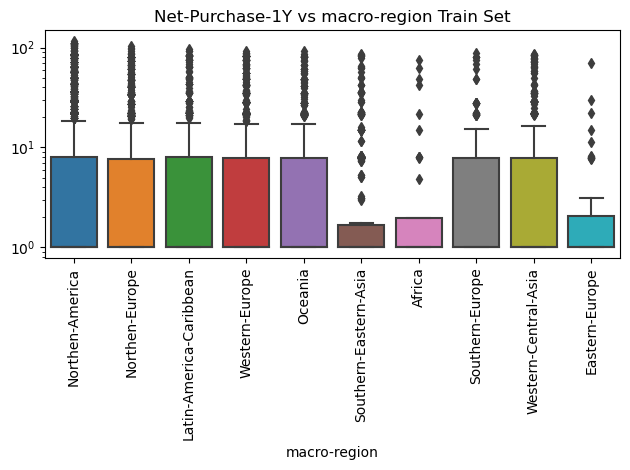

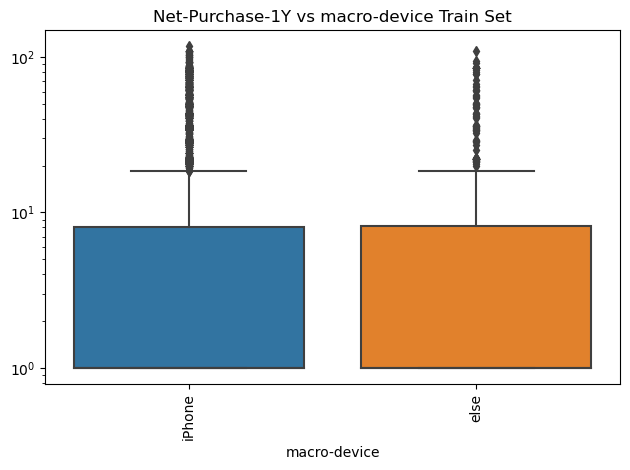

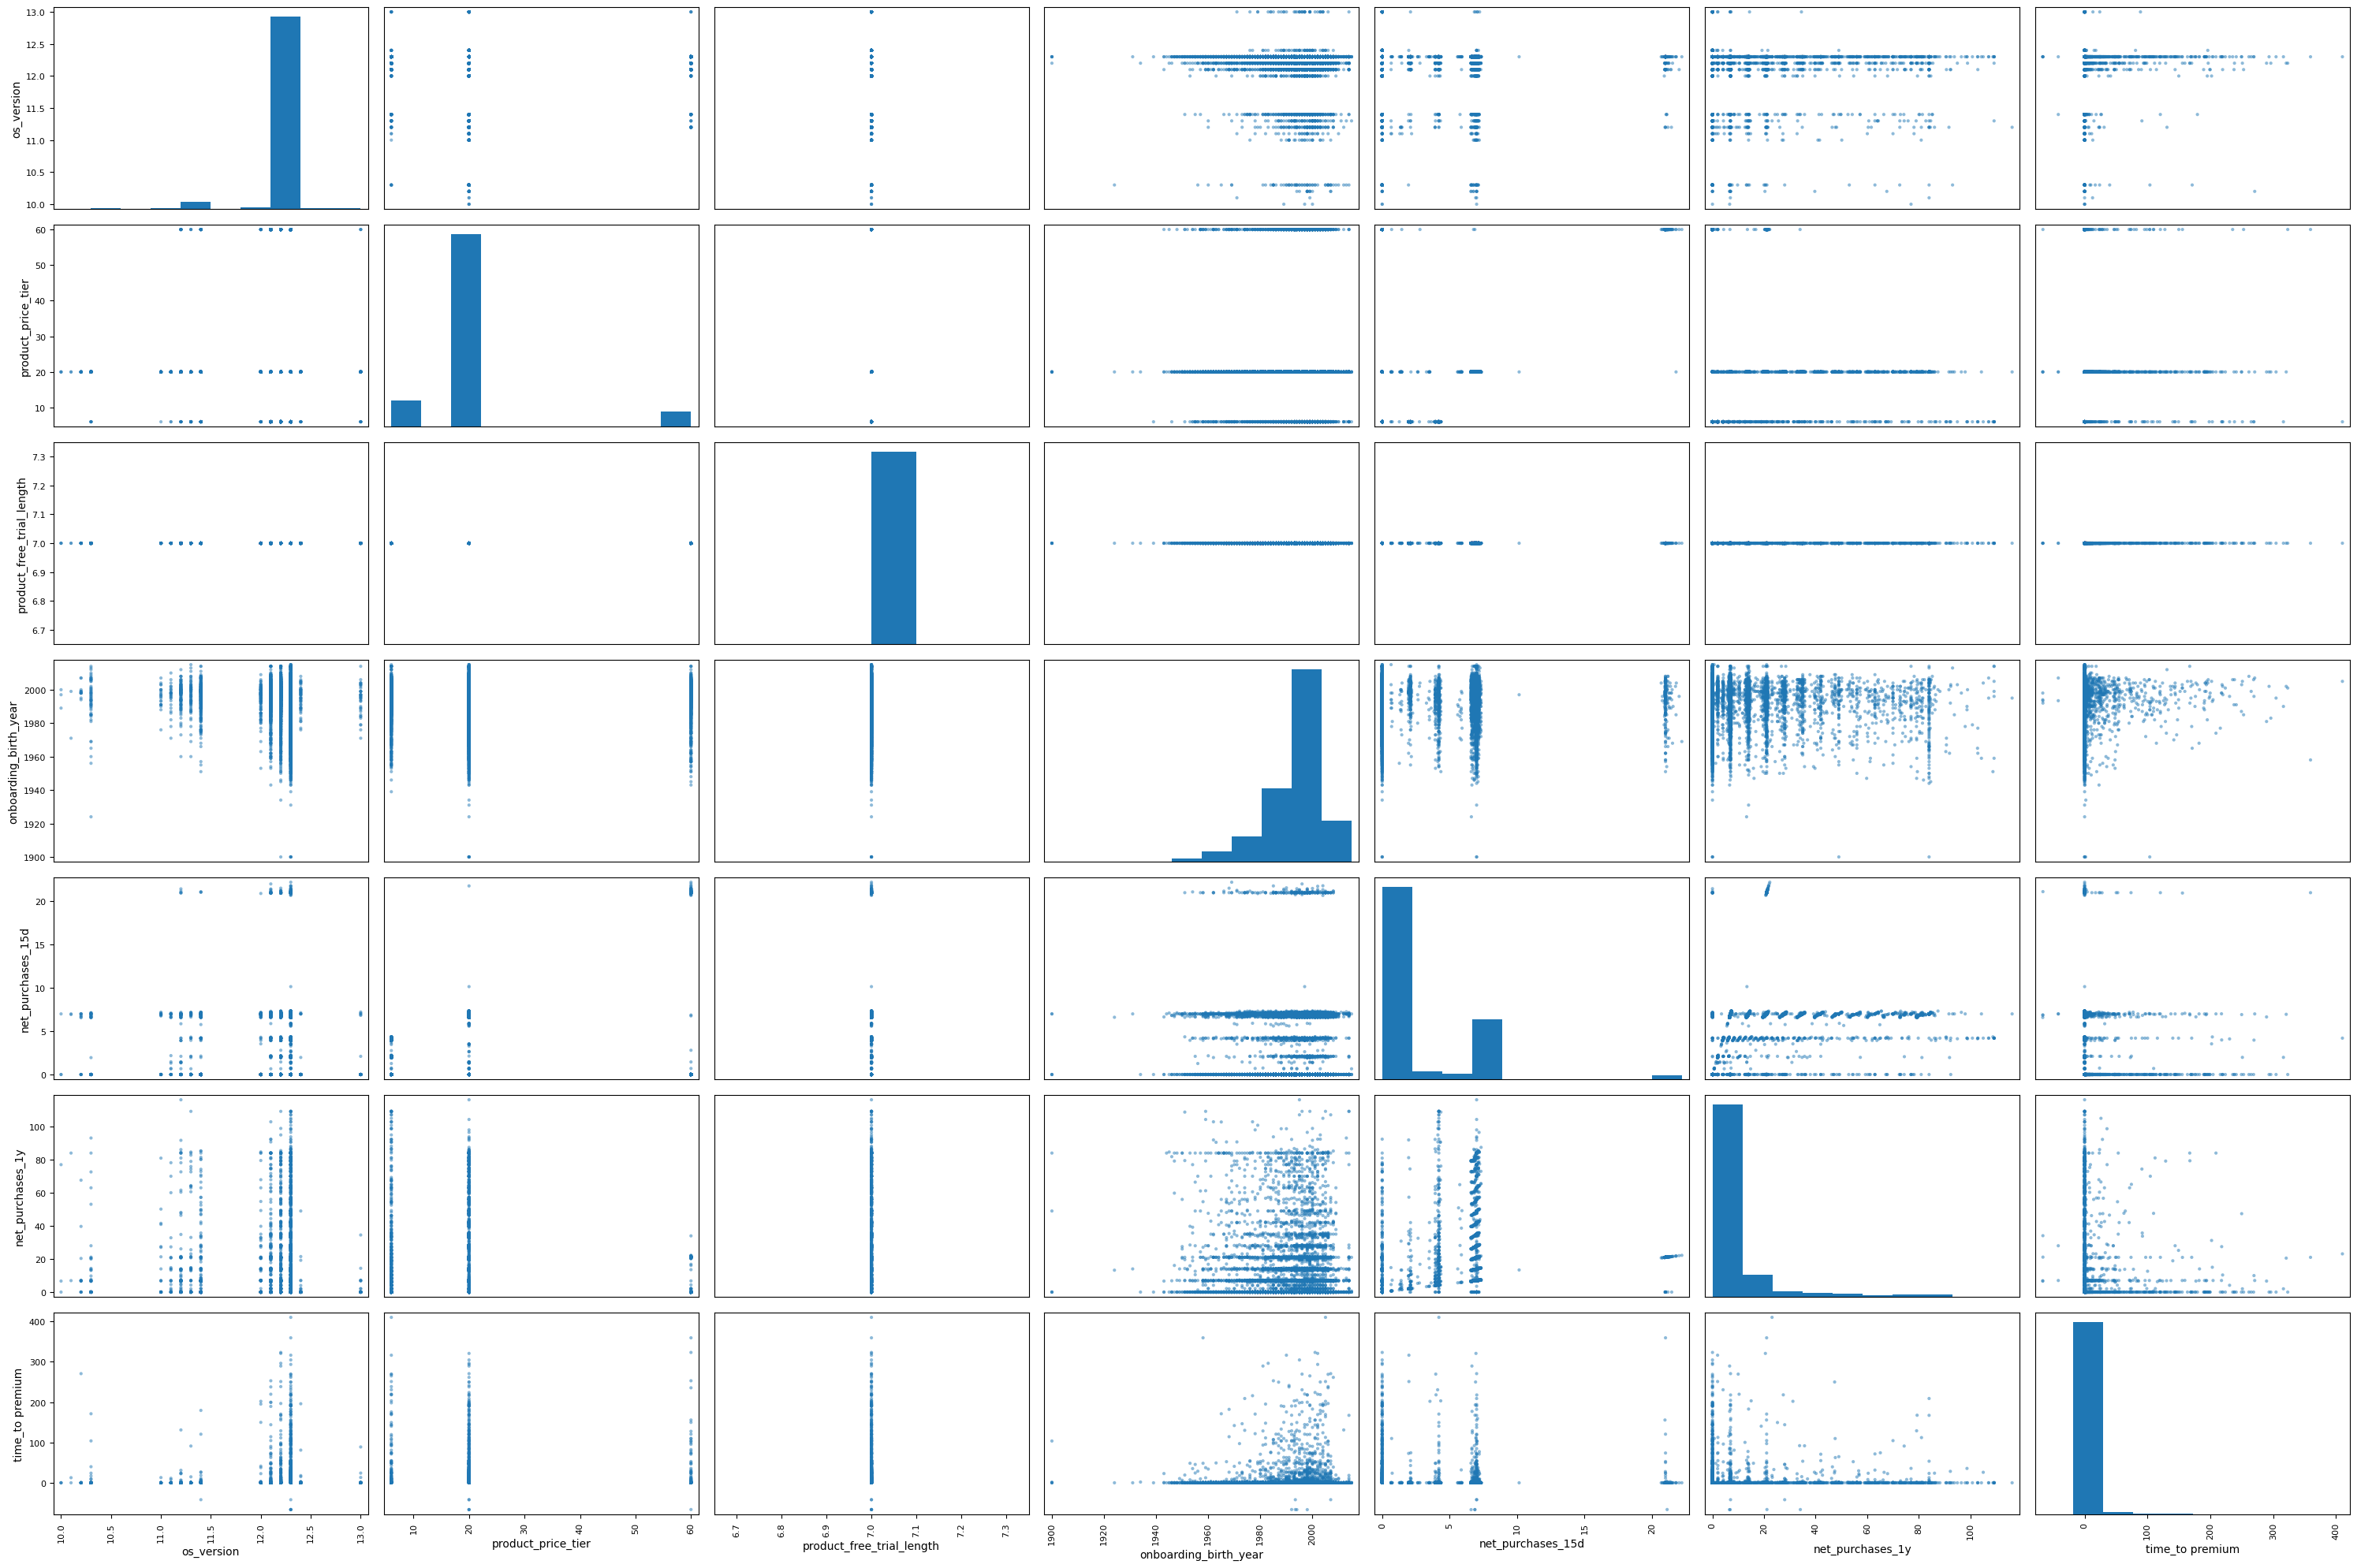

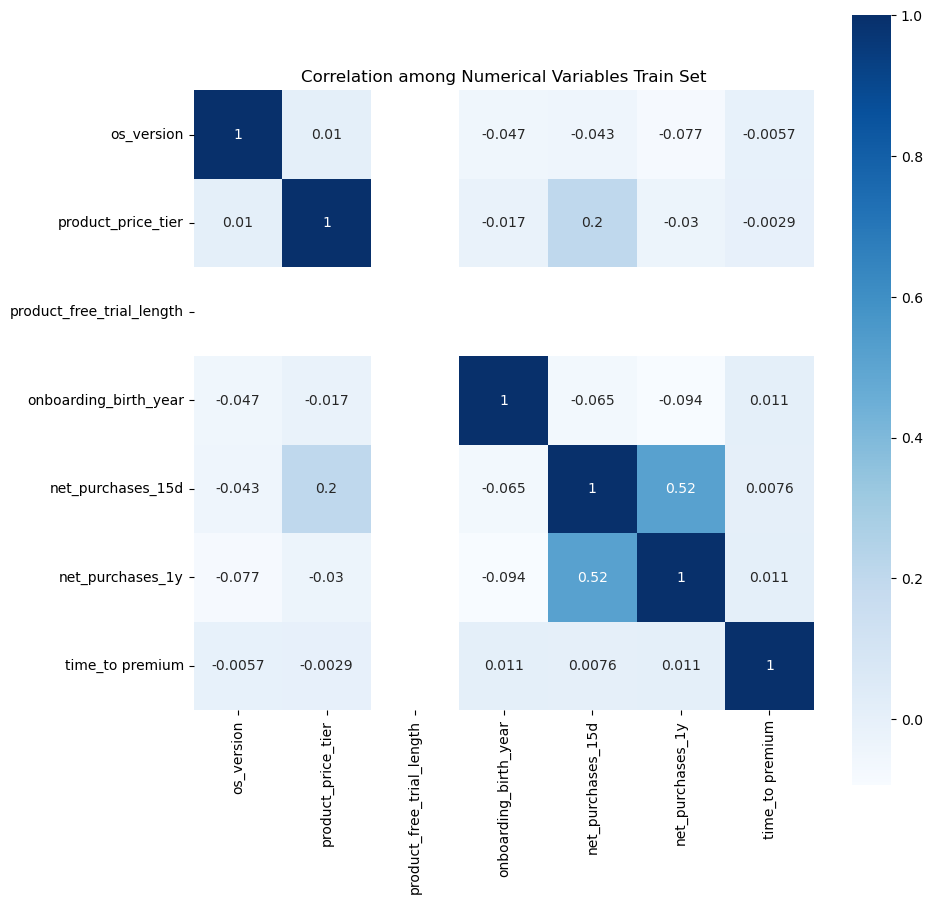

In [5]:
do_plots = True

if do_plots:
    
    # boxplot of target variable versus categorical variables
    for col in col_cat[3:]:
        fig, ax = plt.subplots(1,1)
        sns.boxplot(data=df, x=col, y=df['net_purchases_1y'].values+1)
        ax.set_title(f'Net-Purchase-1Y vs {col} Train Set')
        ax.set_yscale('log')
        plt.xticks(rotation=90)
        fig.tight_layout()
        plt.plot()
    
    # pairplots for numerical variables
    fig, ax = plt.subplots(1,1, figsize=(30,20))
    pd.plotting.scatter_matrix(df[col_num], ax=ax)
    ax.set_title('Pairplot of Numerical Variables Train Set')
    fig.tight_layout()
    
    # correlation plot
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    corr_mat = df[col_num].corr()
    sns.heatmap(corr_mat, square=True, cmap='Blues', annot=True, ax=ax)
    ax.set_title('Correlation among Numerical Variables Train Set')

### 1.6) Design matrix construction
I decide to remove from the analysis the following variables:
1. 'device_type': extremely fragmented categorical variable (33 different models). To consider the type of the device, I just use the 'macro-device' variable since, due to the context, I expect that the difference of behaviour from iphone to ipad/ipod users would be higher than the difference among all the iphones, ipads and ipods specific models. Indeed, iphones, ipad and ipods belong to different market segments, whereas all the iphones to the same.
2. 'product_price_tier': since the three classes of prices exactly belong to the classes of 'product_periodicity', so it is a clone, the info about the type of subscription is already contained in 'product_periodicity'.
3. 'product_free_trial_length': unuseful, since it assumes a unique value (7).

I have tested the following models introducing interactions among the variables, but I ahve observed no significant improvement of the performances, so I don't introduce them in my final delivery.

In [6]:
# design matrix
X = df[['country', 'macro-region', 'language', 'attribution_network', 'product_periodicity', 'onboarding_gender', 'macro-device', 
       'os_version', 'onboarding_birth_year', 'net_purchases_15d', 'time_to premium']]
X_test = df_test[['country', 'macro-region', 'language', 'attribution_network', 'product_periodicity', 'onboarding_gender', 'macro-device', 
       'os_version', 'onboarding_birth_year', 'net_purchases_15d', 'time_to premium']]

# target
y = df['net_purchases_1y']

N = X.shape[0]
N_test = X_test.shape[0]

# one-hot encoding of categorical variables
X_concat = pd.concat([X, X_test])
X_concat = pd.get_dummies(X_concat)
X = X_concat.iloc[:N,:]
X_test = X_concat.iloc[N:,:]


# size of design matrix
d = X.shape[1]
d_test = X_test.shape[1]
print(f'Train set Design matrix size | N: {N} | d: {d}')
print(f'Test set Design matrix size | N: {N_test} | d: {d_test}')

Train set Design matrix size | N: 13370 | d: 65
Test set Design matrix size | N: 3342 | d: 65


In [7]:
for col in col_cat[3:]:
    print('-------')
    print(f'{col}')
    print(f'Train: {df[col].nunique()}')
    print(f'Test: {df_test[col].nunique()}')

-------
country
Train: 17
Test: 23
-------
language
Train: 14
Test: 4
-------
device_type
Train: 33
Test: 32
-------
attribution_network
Train: 5
Test: 5
-------
product_periodicity
Train: 3
Test: 3
-------
onboarding_gender
Train: 3
Test: 3
-------
macro-region
Train: 10
Test: 11
-------
macro-device
Train: 2
Test: 2


### --------------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------------
# 2) Model construction

In [8]:
# seed for reproducibility
np.random.seed(1234)

# K-Fold cross validation object
cv = KFold(n_splits=5, shuffle=True)

### 2.1) Regularized Regression (Ridge)
I perform cross-validation with respect to negative MSE to find the optimal regularization parameter (alpha).

In [9]:
from sklearn.linear_model import RidgeCV, Ridge

# grid search for the regularized model
grid = np.logspace(-4, 2, 500)

# cross validation of optimal alpha choice
reg_cv = RidgeCV(alphas=grid, cv=cv, scoring='neg_mean_squared_error').fit(X, y)
alpha_1 = reg_cv.alpha_

# fit Ridge Model
mod1 = Ridge(alpha=alpha_1)
mod1.fit(X, y)

# predictions on training set
y_hat = mod1.predict(X)

# RMSE on training set
rmse_train = np.sqrt(mean_squared_error(y, y_hat))

print('------------------------------------')
print(f'Ridge Regression | alpha: {round(alpha_1,4)}')
print(f'RMSE train: {round(rmse_train, 3)}')

------------------------------------
Ridge Regression | alpha: 84.6946
RMSE train: 13.357


### 2.2) Regularized Regression (Lasso)
I perform cross-validation to find the optimal regularization parameter (alpha).

In [10]:
from sklearn.linear_model import LassoCV, Lasso

# grid search for the regularized model
grid = np.logspace(-4, 2, 500)

# cross validation of optimal alpha choice
reg_cv = LassoCV(alphas=grid, cv=cv).fit(X, y)
alpha_2 = reg_cv.alpha_

# fit Lasso Model
mod2 = Lasso(alpha=alpha_2)
mod2.fit(X, y)

# predictions on training set
y_hat = mod2.predict(X)

# RMSE on training set
rmse_train = np.sqrt(mean_squared_error(y, y_hat))

print('------------------------------------')
print(f'Lasso Regression | alpha: {round(alpha_2, 4)}')
print(f'RMSE train: {round(rmse_train, 3)}')

------------------------------------
Lasso Regression | alpha: 0.0163
RMSE train: 13.361


### 2.3) Random Forest Regression
I fit a Random Forest regressor hoping that a tree based approach could explain better the non linearities of the phenomenon.
To find its best hyper-parameters, I perform a grid search of the number of trees and maximum depth of the tree.

In [11]:
from sklearn.ensemble import RandomForestRegressor

# grid search of hyper-parameters, set it true to perform it, it takes a while
do_grid_search = False  

if do_grid_search:
    # hyper-parameters grid
    param_grid = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [None, 3, 5, 10, 15, 20]}
    
    # model
    mod3_gs = RandomForestRegressor()
    
    # perform grid search with cross-validation
    gs_cv = GridSearchCV(mod3_gs, param_grid, cv=cv, scoring='neg_mean_squared_error', verbose=3)
    gs_cv.fit(X, y)
    
    # best parameters
    best_max_depth = gs_cv.best_params_['max_depth']
    best_n_trees = gs_cv.best_params_['n_estimators']
    

# optimal parameters (output of the grid search)
best_n_trees_3 = 100
best_max_depth_3 = 3

# fit Random Forest Regressor
mod3 = RandomForestRegressor(n_estimators=best_n_trees_3, max_depth=best_max_depth_3)
mod3.fit(X, y)

# predictions on training set
y_hat = mod3.predict(X)

# RMSE on training set
rmse_train = np.sqrt(mean_squared_error(y, y_hat))

print('------------------------------------')
print(f'Random Forest | n_trees: {best_n_trees_3} | max_depth: {best_max_depth_3}')
print(f'RMSE train: {round(rmse_train, 3)}')

------------------------------------
Random Forest | n_trees: 100 | max_depth: 3
RMSE train: 12.541


### 2.4) Gradient Boosting
I fit a Gradient Boosting regressor using a different tree based approach. To find its best hyper-parameters, I perform a grid search of the number of trees, the maximum depth of the tree and the learning rate.

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

# grid search of hyper-parameters, set it true to perform it, it takes a while
do_grid_search = False  

if do_grid_search:
    # hyper-parameters grid
    param_grid = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [None, 3, 5, 10, 15, 20], 'learning_rate': [0.001, 0.01, 0.1, 0.2]}
    
    # model
    mod4_cv = GradientBoostingRegressor()
    
    # perform grid search with cross-validation
    gs_cv = GridSearchCV(mod4_cv, param_grid, cv=cv, scoring='neg_mean_squared_error', verbose=3)
    gs_cv.fit(X, y)
    
    # best parameters
    best_max_depth_4 = gs_cv.best_params_['max_depth']
    best_n_trees_4 = gs_cv.best_params_['n_estimators']
    best_lr_4 = gs_cv.best_params_['learning_rate']


# optimal parameters (output of the grid search)
best_n_trees_4 = 50
best_max_depth_4 = 3
best_lr_4 = 0.1

# fit Gradient Boosting
mod4 = GradientBoostingRegressor(n_estimators=best_n_trees_4, max_depth=best_max_depth_4, learning_rate=best_lr_4)
mod4.fit(X, y)

# predictions on training set
y_hat = mod4.predict(X)

# RMSE on training set
rmse_train = np.sqrt(mean_squared_error(y, y_hat))

print('------------------------------------')
print(f'Gradient Boosting | n_trees: {best_n_trees_4} | max_depth: {best_max_depth_4} | lr: {best_lr_4}')
print(f'RMSE train: {round(rmse_train, 3)}')


------------------------------------
Gradient Boosting | n_trees: 50 | max_depth: 3 | lr: 0.1
RMSE train: 12.299


### --------------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------------
# 3) Model selection

# 3.1) K-Fold Cross-Validation
I evaluate the RMSE of each model with K-Fold Cross-Validation, setting k=10.

In [13]:
# cross-validation 
np.random.seed(1234)

# K-Fold cross validation object
cv = KFold(n_splits=5, shuffle=True)

# model 1
mod1_cv = Ridge(alpha=alpha_1)
rmse_list_1 = np.sqrt(-cross_val_score(mod1_cv, X, y, cv=cv, scoring='neg_mean_squared_error'))

# model 2
mod2_cv = Lasso(alpha=alpha_2)
rmse_list_2 = np.sqrt(-cross_val_score(mod2_cv, X, y, cv=cv, scoring='neg_mean_squared_error'))

# model 3
mod3_cv = RandomForestRegressor(n_estimators=best_n_trees_3, max_depth=best_max_depth_3)
rmse_list_3 = np.sqrt(-cross_val_score(mod3_cv, X, y, cv=cv, scoring='neg_mean_squared_error'))

# model 4
mod4_cv = GradientBoostingRegressor(n_estimators=best_n_trees_4, max_depth=best_max_depth_4, learning_rate=best_lr_4)
rmse_list_4 = np.sqrt(-cross_val_score(mod4_cv, X, y, cv=cv, scoring='neg_mean_squared_error'))

# collect results
tab_rmse = pd.DataFrame({
    'model': ['mod1', 'mod2', 'mod3', 'mod4'], 
    'mean-rmse': [np.mean(rmse_list_1), np.mean(rmse_list_2), np.mean(rmse_list_3), np.mean(rmse_list_4)],
    'std-rmse': [np.std(rmse_list_1), np.std(rmse_list_2), np.std(rmse_list_3), np.std(rmse_list_4)]
})

print('--------')
print('KFold Cross-Validation')
print(tab_rmse)

--------
KFold Cross-Validation
  model  mean-rmse  std-rmse
0  mod1  13.390382  0.287844
1  mod2  13.379493  0.694762
2  mod3  12.648123  0.581562
3  mod4  12.648219  0.366754


### 3.2) Model choice <a id='model_choice'></a>
Apparently the best model is model 3, since it provides the lowest mean RMSE with Cross-Validation. I perform a non-parametric test to assess this fact, testing the alternative hypotesis that Model 3 RMSE is lower than the RMSE of the other models using the results of cross-validation.

I see that I have quite strong statistical evidence to affirm that Model 3 has lower RMSE than Model 1 and 2 (low p-values of the test) whereas this is not true for Model 4. Indeed, the p-value of the test is very high.

In any case, I select as final choice Model 3 since the difference between RMSE of training set and mean RMSE of K-Fold CV is lower than the one of Model 4 (0.107 vs 0.349). This is an indication of better generalization performances of the model and more robusteness towards over-fitting. 

In [14]:
from scipy.stats import wilcoxon

test_better = wilcoxon(rmse_list_3, rmse_list_1, alternative='less')
print(f'Test Random Forest RMSE < Ridge RMSE: p-value={round(test_better[1], 4)}')

test_better = wilcoxon(rmse_list_3, rmse_list_2, alternative='less')
print(f'Test Random Forest RMSE < Lasso RMSE: p-value={round(test_better[1], 4)}')

test_better = wilcoxon(rmse_list_3, rmse_list_4, alternative='less')
print(f'Test Random Forest RMSE < Gradient Boosting RMSE: p-value={round(test_better[1], 4)}')

Test Random Forest RMSE < Ridge RMSE: p-value=0.0625
Test Random Forest RMSE < Lasso RMSE: p-value=0.0625
Test Random Forest RMSE < Gradient Boosting RMSE: p-value=0.6875


### --------------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------------
# 4) Model inspection

## 4.1) Feature analysis <a id='feature_analysis'></a>
I compute the 'feature importance' of each variable of the fitted Rabdom Forest Regressor. Comparing this result with the visual inspection of the variables (Section 1.5), I observe the following facts:

1. 'net_purchases_15d' is the most important variable to predict the target, since it has a very high score. The two are positively correlated (correlation coefficient = 0.52). The impact of all the other variables is considerably lower (0.94 vs 0.04 or less).
2. 'onboarding_birth_year' is the second most important factor. Since it is negatively correlated with the target (correlatin coefficient = -0.095), it means that older users are more likely to produce higher purchase.
3. 'os_version' is the third most important factor. Since it is negatively correlated with the target (correlatin coefficient = -0.075), it means that users with older version of the os (so, presumably, with older devices) are more likely to produce higher purchase.
4. The waiting time before subscribing to the premium version looks to have a relevant role. The correlation coefficient is almost null (0.013) and from the pairplot I see the relation between the two variables is very non-linear, so I can't say if there is a positive or negative correlation. This non-linear relation would be an interesting aspect to further study.
5. Oceania is a macro-region associated to very high 1 year purchase ('macro-region = Oceania' in the top 5 feature importance scores).

----------
Top 5 feature importance scores
net_purchases_15d        0.945023
onboarding_birth_year    0.035677
os_version               0.011640
macro-region_Oceania     0.002386
time_to premium          0.002082
dtype: float64


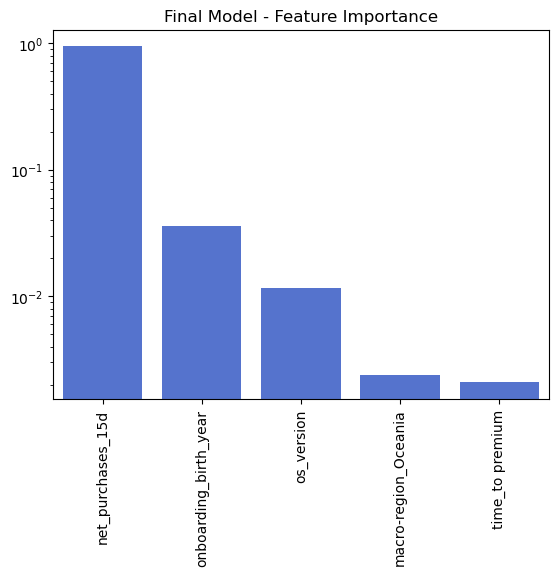

In [15]:
mod_final = mod3

# feature importance
feat_imp = pd.Series(mod_final.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False)

fig, ax = plt.subplots(1,1)
sns.barplot(x=feat_imp[:5].index, y=feat_imp[:5].values, ax=ax, color='royalblue')
plt.xticks(rotation=90)
ax.set_yscale('log')
ax.set_title('Final Model - Feature Importance')

print('----------')
print('Top 5 feature importance scores')
print(feat_imp[:5])

## 4.2) Output Genaration
I store the array of the predictions in the csv file 'final_submission.csv'.

(array([2.367e+03, 4.600e+01, 2.000e+00, 3.000e+00, 7.890e+02, 6.500e+01,
        5.400e+01, 1.100e+01, 2.000e+00, 3.000e+00]),
 array([ 0.83870751,  5.30050958,  9.76231164, 14.22411371, 18.68591577,
        23.14771784, 27.60951991, 32.07132197, 36.53312404, 40.99492611,
        45.45672817]),
 <BarContainer object of 10 artists>)

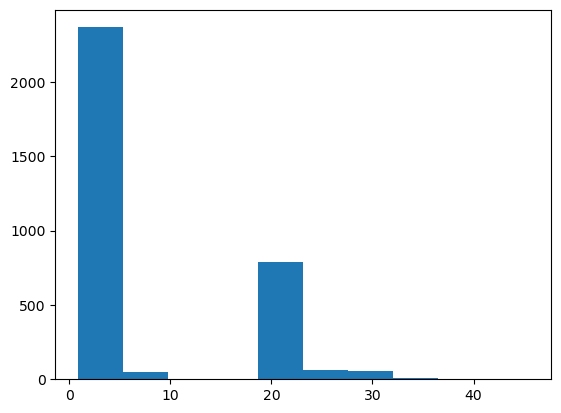

In [20]:
# produce prediction of the test set
y_pred_test = mod_final.predict(X_test)

# save them on csv file
df_candidate = pd.DataFrame({"y_pred_test": y_pred_test})
df_candidate.to_csv("final_submission.csv", index=False)

## 4.3) Conclusions
I recap the questions you asked me and where you can find the answer:

1. *Which model did you choose and why?* See [Section 3.2](#model_choice)


2. *What are the most predictive features?* See [Section 4.1](#feature_analysis)


3. *How did you handle outliers and missing values in the dataset?* Outliers: see [Section 1.4](#outliears), Missing values: see [Section 1.2](#nans)


4. *Would it be possible to improve the modelâ€™s performance by adding more data available in the first 15 days since subscription?* I think so. Indeed, we have shown that the most important feature is the net purchase in the first 15 days and the time to pass to the premium account is a very important variable too. These two are strictly related to the behaviour of the users in their first 15 days, so it looks that having precise information about this period can be crucial to better predict the 1 year purchase. More variables related to this peridod (such as time spent by the user on the app or the interaction with specific functionalities) could be used to improve the performances of the model.


5. *Did you discover any non-trivial insights in the data which could help you build a better model?* We have shown ([Section 4.1](#feature_analysis), point 4) that the waiting time before the subscription to the premium service and the yearly purchase have a non trivial non linear relation. We have been able to capture it with random tree based approach, but up to now we don't have a straightforward explaination (the correlation index is almost null). This relation could be further studied employing non-linear models and transformations to improve the performances of the predictor and our knowledge about the phenomenon. Moreover, the fact that the onboarding birth year and the os versions are negatively correlated with the purchase suggests that for this specific app older people (with older devices) are the most profitable customers. Better investigating the behaviour of the customers according to their age and characteristics of the device could be exploited to build a better model.